In [9]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

T = 60
P = 7
M = 4
R = 0.8
F = 0.0005
N=50

In [10]:
def GetData(file_name):
    return pd.DataFrame(pd.read_csv(file_name, usecols= [1,2,3]))
df= GetData('DATA.csv')

In [11]:
def PartitionData(data):
    date_to_index={}
    i=0
    while(i<87779):
        date_to_index[str(data['datadate'][i])]= i
        i+=30
        
    
    
    return np.array_split(data,2926),date_to_index

In [12]:
def GetBalanced(prices, weights, balance):
    
    to_invest= balance*R
    
    tot= np.sum(weights)
    weights= weights/tot
    
    return weights*to_invest

In [13]:
def GetMomentumBasedPriority(PartitionedDataFrameList, DateToIndex ,t):

    today=str(t)
    NdaysAgo = datetime.date(int(today[0:4]),int(today[4:6]),int(today[6:])) + datetime.timedelta(days = -N)
    NdaysAgo_date= NdaysAgo.strftime("%Y") + NdaysAgo.strftime("%m") + NdaysAgo.strftime("%d")
    
    if NdaysAgo_date not in DateToIndex:
        
        i=0
        while True:
            NdaysAgo = datetime.date(int(today[0:4]),int(today[4:6]),int(today[6:])) + datetime.timedelta(days = -N-i)
            NdaysAgo_date= NdaysAgo.strftime("%Y") + NdaysAgo.strftime("%m") + NdaysAgo.strftime("%d")
            if NdaysAgo_date in DateToIndex:
                break
            else:
                i+=1
                
    f=PartitionedDataFrameList
    g=DateToIndex
    diff= np.array([(f[int(g[today]/30)]['adjcp'][g[today]+j] - f[int(g[NdaysAgo_date]/30)]['adjcp'][g[NdaysAgo_date]+j]) for j in range(0,30)])
    
    total= np.array(f[int(g[today]/30)]['adjcp'])
    
    for i in range( g[NdaysAgo_date] , g[today] ,30 ):
        
        total += np.array(f[int(i/30)]['adjcp'])

    momentum_mean= (diff * N)/total
    return momentum_mean
            
            

In [14]:
def Switch(firstStock, SecondStock, today ,PartitionedDataFrames,DateToIndex):
     
        mom= GetMomentumBasedPriority(PartitionedDataFrames, DateToIndex ,today)
            
        if( mom [firstStock] > mom[SecondStock]):
            return mom[firstStock]
        else:
            return mom[SecondStock]

In [19]:
class PortFolio:
    def __init__(self,balance):
        self.balance = balance
        self.shares = np.zeros(30)
        self.prices = np.zeros(30)
        self.pairs_list = []
        for i in range(M):
            self.pairs_list.append(tuple([-1.-1]))
    #Initialize all variables

    def SellStock(self,index):
        #index : The index of the Stock to sell (0-29)
        self.balance += self.shares[index]*self.prices[index]*(1-F)
        self.shares[index] = 0
        
    
  
    def BuyStock(self,index,number):
      
        self.shares[index] += number
        self.balance -= self.prices[index]*number*(1+F)
        
    def CalculateNetWorth(self):
        net_worth = 0
        for j in range(0,30):
            net_worth += self.prices[j]*self.shares[j]
        return net_worth + self.balance


    def ChangePricesTo(self, newPriceVector):
        for i in range(0,30):
            self.prices[i] = newPriceVector[i]
            
    def ChangePairs(self,PartitionedDataFrames,DateToIndex,today):  
    # Calls the Switch function for all the pairs of stocks owned
    
            for i in range(0,len(self.pairs_list)):
                better_stock = Switch(self.pairs_list[i][0],self.pairs_list[i][1], today ,PartitionedDataFrames,DateToIndex)
                if(self.shares[better_stock] != 0):
                    pass
                else:
                    if(better_stock == self.pairs_list[i][0]):
                        self.BuyStock(self.pairs_list[i][0],self.shares[self.pairs_list[i][1]])
                        self.SellStock(self.pairs_list[i][1])
                        
                    else: 
                        self.BuyStock(self.pairs_list[i][1],self.shares[self.pairs_list[i][0]])
                        self.SellStock(self.pairs_list[i][0])
                        
        
  
    def RebalancePortfolio(self,PartitionedDataFrames,DateToIndex,today):
    
        arr = np.zeros((30,T))
        corr = np.ones((30,30))
        arr2 = np.zeros(30)
        for i in range(30):           
            h = 0
            for j in range(DateToIndex[int(today)]-T+1,DateToIndex[int(today)]+1):
                arr[i][h] = PartitionedDataFrames[j].iloc[i]['adjcp']
                h += 1
        for i in range(30):
            for j in range(i+1,30):
                C = np.corrcoef(arr[i],arr[j]) 
                corr[i][j] = corr[j][i] = C[0][1] 
        
        for i in range(30):
            arr2[i] = corr[i].min()
        arr2 = np.sort(arr2)[::-1]
        while(len(arr2) != M):
            arr2 = np.delete(arr2,len(arr2)-1)
        for i in range(M):
            x = np.where(corr == arr2[i])
            self.pairs_list[i] = tuple([x[0][0],x[1][0]])
        self.ChangePairs(PartitionedDataFrames,DateToIndex,today)

In [16]:
initbal = 500
myPortfolio = PortFolio(initbal)
NetWorthAfterEachTrade = []


Data = GetData('DATA.csv')
PartitionedData, DateToIndex= PartitionData(Data)
for j in range(30):
    myPortfolio.BuyStock(j,20)

t = T
for i in range(T+1,len(DateToIndex.keys())):
    for j in range(30):
        myPortfolio.recPric[j] = PartitionedData[i].iloc[j][2]
    NetWorthAfterEachTrade.append(myPortfolio.CalculateNetWorth())
    if(t != T):
        t += 1
        continue
    else:
        t = 0
        if(myPortfolio.currBal < R*initbal):
            continue
    myPortfolio.RebalancePortfolio(PartitionedData, DateToIndex,list(DateToIndex.keys())[i]) 

In [17]:
def VisualizeData(list,d1,d2):
    
    x=(np.array([i for i in range(d1,d2)])).T
    plt.plot(x.T, list[d1:d2])
    plt.xlabel('days')
    plt.ylabel('networth')
    plt.show()


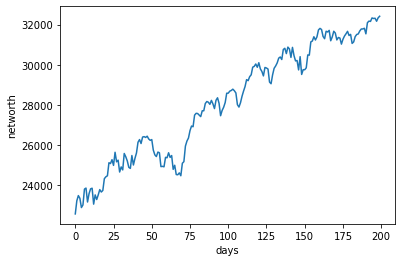

In [18]:
VisualizeData(NetWorthAfterEachTrade,0,200)